In [1]:
import requests
import json
import pandas as pd

In [2]:
from src.paychex_ml.external_data import get_unemployment_rate

In [3]:
df = get_unemployment_rate()

Loaded LNS14000000 data


In [4]:
df

,year,period,periodName,latest,value
0,2022,M02,February,true,3.8
1,2022,M01,January,NaN,4.0
2,2021,M12,December,NaN,3.9
3,2021,M11,November,NaN,4.2
4,2021,M10,October,NaN,4.6
...,...,...,...,...,...
81,2015,M05,May,NaN,5.6
82,2015,M04,April,NaN,5.4
83,2015,M03,March,NaN,5.4
84,2015,M02,February,NaN,5.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        86 non-null     object 
 1   period      86 non-null     object 
 2   periodName  86 non-null     object 
 3   latest      1 non-null      object 
 4   value       86 non-null     float64
dtypes: float64(1), object(4)
memory usage: 3.5+ KB


In [6]:
df['date'] = pd.to_datetime(df['year'] + df['periodName'], format="%Y%B").dt.to_period('M')

In [7]:
df

,year,period,periodName,latest,value,date
0,2022,M02,February,true,3.8,2022-02
1,2022,M01,January,NaN,4.0,2022-01
2,2021,M12,December,NaN,3.9,2021-12
3,2021,M11,November,NaN,4.2,2021-11
4,2021,M10,October,NaN,4.6,2021-10
...,...,...,...,...,...,...
81,2015,M05,May,NaN,5.6,2015-05
82,2015,M04,April,NaN,5.4,2015-04
83,2015,M03,March,NaN,5.4,2015-03
84,2015,M02,February,NaN,5.5,2015-02


<AxesSubplot:>

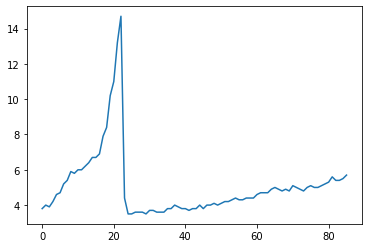

In [8]:
df.value.plot()